In [1]:
!pip install rfpimp
!pip install category_encoders
!pip install pandas-profiling

In [2]:
# Import all the modules that were used in this project
import numpy as np
import pandas as pd
import warnings
import category_encoders as ce
from rfpimp import *
import seaborn as sns
from sklearn import tree
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_string_dtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from pandas_profiling import ProfileReport
warnings.filterwarnings("ignore")

C:\Users\Danielle\AppData\Local\Temp\ipykernel_10068\4243845560.py:15: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [3]:
#Function to evaluate two methods: Logistic regression and Decision Tree Classifier

#X = Dataset without the target column
#y = Target column

def evaluate(X, y, modelType):

    #Creating lists to store performance results
    accuracy_score_list = []
    precision_score_list = []
    recall_score_list = []
    f1_Score_list = []

    #Evaluating in 10 attemps
    for i in range(10):
      if modelType == 'Logistic Regression':
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
          model = LogisticRegression()
          model.fit(X_train, y_train)
          y_pred = model.predict(X_test)

          accuracy_score_list.append(accuracy_score(y_test, y_pred))
          precision_score_list.append(precision_score(y_test, y_pred))
          recall_score_list.append(recall_score(y_test, y_pred))
          f1_Score_list.append(f1_score(y_test, y_pred))

          avg_accuracy_score = sum(accuracy_score_list) / len(accuracy_score_list)
          avg_precision_score = sum(precision_score_list) / len(precision_score_list)
          avg_recall_score = sum(recall_score_list) / len(recall_score_list)
          avg_f1_score = sum(f1_Score_list) / len(f1_Score_list)

          print("Accuracy Score: ", avg_accuracy_score)
          print("Precision Score: ", avg_precision_score)
          print("Recall Score: ", avg_recall_score)
          print("F1 Score", avg_f1_score)

          return model, X_train, X_test, y_train, y_test, y_pred

      elif modelType == 'Decision Tree':
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

          # Create and train your Decision Tree classifier on X_train and y_train
          model = DecisionTreeClassifier(random_state=1234, max_depth=4)
          model.fit(X_train, y_train)

          # Make predictions on the testing set
          y_pred = model.predict(X_test)

          # Perform cross-validation to assess performance
          scores = cross_val_score(model, X, y, cv=5)

          accuracy_score_list.append(accuracy_score(y_test, y_pred))
          precision_score_list.append(precision_score(y_test, y_pred))
          recall_score_list.append(recall_score(y_test, y_pred))
          f1_Score_list.append(f1_score(y_test, y_pred))

          avg_accuracy_score = sum(accuracy_score_list) / len(accuracy_score_list)
          avg_precision_score = sum(precision_score_list) / len(precision_score_list)
          avg_recall_score = sum(recall_score_list) / len(recall_score_list)
          avg_f1_score = sum(f1_Score_list) / len(f1_Score_list)

          print("Accuracy Score: ", avg_accuracy_score)
          print("Precision Score: ", avg_precision_score)
          print("Recall Score: ", avg_recall_score)
          print("F1 Score", avg_f1_score)

          return model, X_train, X_test, y_train, y_test, y_pred

      else:
          raise ValueError("Unsupported modelType. Supported values are 'Logistic Regression' and 'Decision Tree'")

#Function to see the feature importance
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='silver')

#Function to transpose a table to check variables easily (by types, % of missing, N° of unique values, and values)
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

#Function to normalize strings
def df_normalize_strings(df, patt):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace(patt, np.nan)

#Function to transform strings in categorical variables
def df_string_to_cat(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

#Function to transform strings in categorical variables
def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

#Function to replace null values by median
def fix_missing_num(df, colname):
    df[colname].fillna(df[colname].median(), inplace=True)

#Function to divide tenure in groups based on distribution
def tenure_lab(df) :

    if df["Tenure"] <= 30:
        return "Tenure_0-30"
    elif (df["Tenure"] > 30) and (df["Tenure"] <= 50 ):
        return "Tenure_30-50"
    elif (df["Tenure"] > 50) and (df["Tenure"] <= 61) :
        return "Tenure_50-60"

def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lr= Q1-(1.5 * IQR)
    ur= Q3+(1.5 * IQR)
    return lr, ur


#DATA CLEANING PROCESS

In [4]:
chr = pd.read_csv("https://raw.githubusercontent.com/joncalle/ML2/main/ChurnData.csv") #Importing dataset from github repository
chr = chr.drop(['CustomerID'], axis=1) #CustomerID is an ID/Secuential info, it is not need it.
print(chr.shape) #Print rows, columns
chr.head(10).T   #Dump first 2 rows

(5630, 19)


,0,1,2,3,4,5,6,7,8,9
Churn,1,1,1,1,1,1,1,1,1,1
Tenure,4.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,13.0,NaN
PreferredLoginDevice,Mobile Phone,Phone,Phone,Phone,Phone,Computer,Phone,Phone,Phone,Phone
CityTier,3,1,1,3,1,1,3,1,3,1
WarehouseToHome,6.0,8.0,30.0,15.0,12.0,22.0,11.0,6.0,9.0,31.0
PreferredPaymentMode,Debit Card,UPI,Debit Card,Debit Card,CC,Debit Card,Cash on Delivery,CC,E wallet,Debit Card
Gender,Female,Male,Male,Male,Male,Female,Male,Male,Male,Male
HourSpendOnApp,3.0,3.0,2.0,2.0,NaN,3.0,2.0,3.0,NaN,2.0
NumberOfDeviceRegistered,3,4,4,4,3,5,3,3,4,5
PreferedOrderCat,Laptop & Accessory,Mobile,Mobile,Laptop & Accessory,Mobile,Mobile Phone,Laptop & Accessory,Mobile,Mobile,Mobile


In [5]:
#Verifying if there are missing values
chr.isna().sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [6]:
#Using of sniff_modified formula to check the % of missing values and what variables are involve.
sniff_modified(chr)

,data type,percent missing,No. unique,unique values
Churn,int64,0.000000,2,"[1, 0]"
Complain,int64,0.000000,2,"[1, 0]"
NumberOfAddress,int64,0.000000,15,"[9, 7, 6, 8, 3, 2, 4, 10, 1, 5, 19, 21, 11, 20..."
SatisfactionScore,int64,0.000000,5,"[2, 3, 5, 4, 1]"
NumberOfDeviceRegistered,int64,0.000000,6,"[3, 4, 5, 2, 1, 6]"
CashbackAmount,int64,0.000000,220,"[160, 121, 120, 134, 130, 139, 123, 127, 295, ..."
CityTier,int64,0.000000,3,"[3, 1, 2]"
HourSpendOnApp,float64,4.529307,7,"[3.0, 2.0, nan, 1.0, 0.0, 4.0, 5.0]"
WarehouseToHome,float64,4.458259,35,"[6.0, 8.0, 30.0, 15.0, 12.0, 22.0, 11.0, 9.0, ..."
DaySinceLastOrder,float64,5.452931,23,"[5.0, 0.0, 3.0, 7.0, 2.0, 1.0, 8.0, 6.0, 4.0, ..."


In [7]:
#3 types of incorrect features were detected. They were normalized.
patt = ['unknown','xxxxx','   ']
df_normalize_strings(chr, patt)

In [8]:
#Selecting numeric features to work on how to fill missing values.
chr_num_columns = chr.select_dtypes(include=[np.number])

# Filling the missing values with median
for column_name in chr_num_columns.columns:
    print(column_name)
    fix_missing_num(chr, column_name)

Churn
Tenure
CityTier
WarehouseToHome
HourSpendOnApp
NumberOfDeviceRegistered
SatisfactionScore
NumberOfAddress
Complain
OrderAmountHikeFromlastYear
CouponUsed
OrderCount
DaySinceLastOrder
CashbackAmount


In [9]:
#Creating of tenure groups in order to improve analysis
chr["tenure_group"] = chr.apply(lambda chr:tenure_lab(chr), axis = 1)

Text(0, 0.5, 'Values')

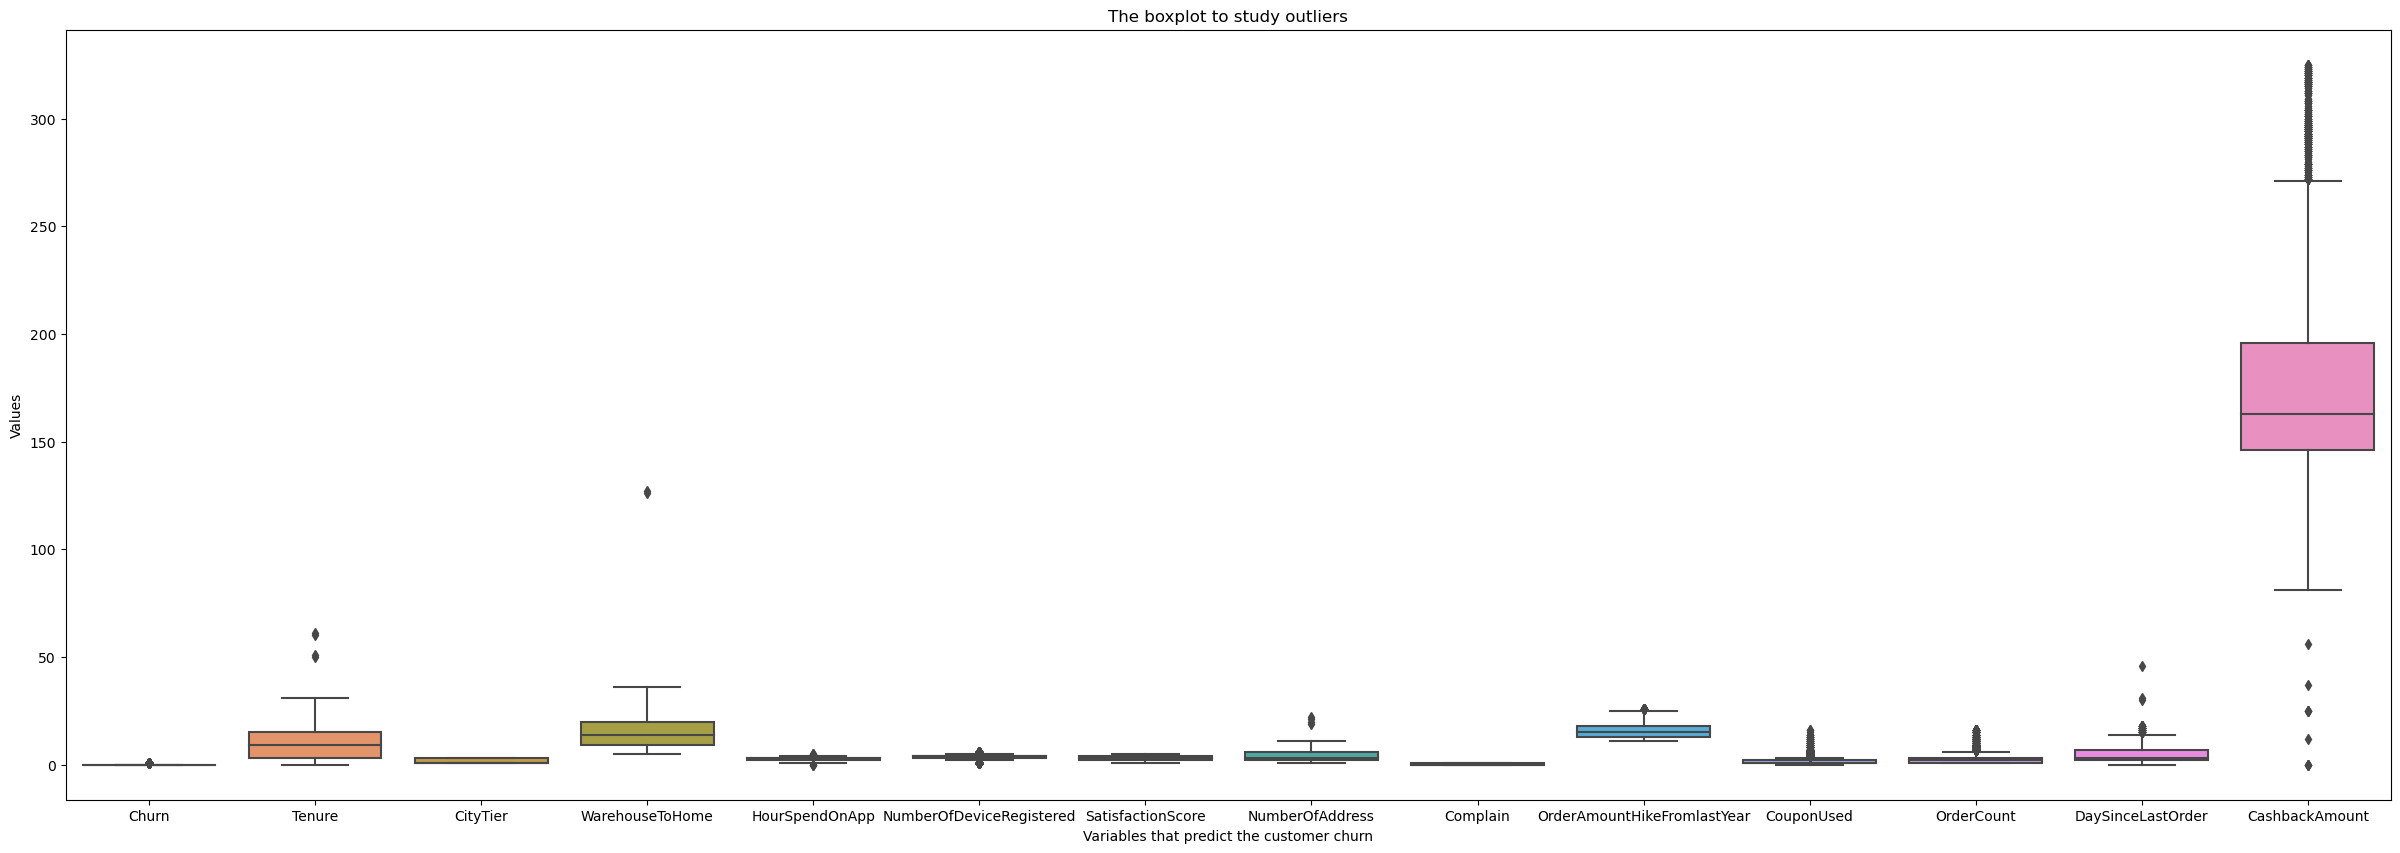

In [10]:
#Treatment of outliers
plt.figure(figsize=(30,10))
sns.boxplot(data=chr)
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the customer churn')
plt.ylabel('Values')

There could have possible outliers. Quantile method will be used to treat them. According to the theory, values beyond 1.5*Q1 and 1.5*Q3 will be considered as possible outliers. This method is useful because there is no distributional assumption associated with them.

In [11]:
#Removing possible outliers that could negatively affect the final result
num_bloxplot = list(chr.select_dtypes(exclude='object').columns)
num_bloxplot.remove('Churn')

for column in num_bloxplot:
    if chr[column].dtype != 'object':
        lr,ur=remove_outlier(chr[column])
        chr[column]=np.where(chr[column]>ur,ur,chr[column])
        chr[column]=np.where(chr[column]<lr,lr,chr[column])

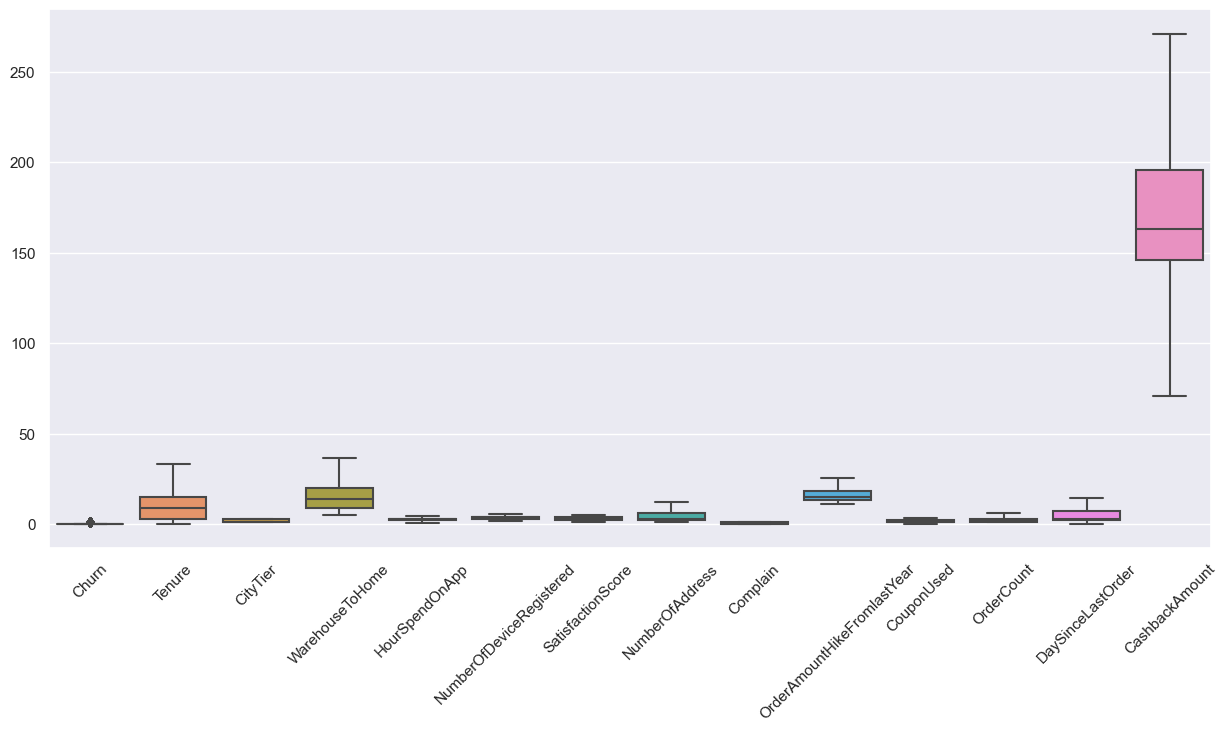

In [12]:
#Plotting the dataset with no possible outliers
sns.set(style="darkgrid", palette="muted")
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(data=chr)
plt.xticks(rotation=45)
plt.show()

In [13]:
#Verifying if there are missing values
chr.isna().sum()

Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
tenure_group                   0
dtype: int64

#EXPLORATORY DATA ANALYSIS

#####CATEGORICAL VARIABLES

In [28]:
#Selecting only non-numerical variables
chr_str = chr.select_dtypes(include=[object])

#Merging categorical variables with churn values
chr_str = pd.concat([chr_str, chr['Churn']], axis=1)

#Creating a copy
chr_str_plt = chr_str

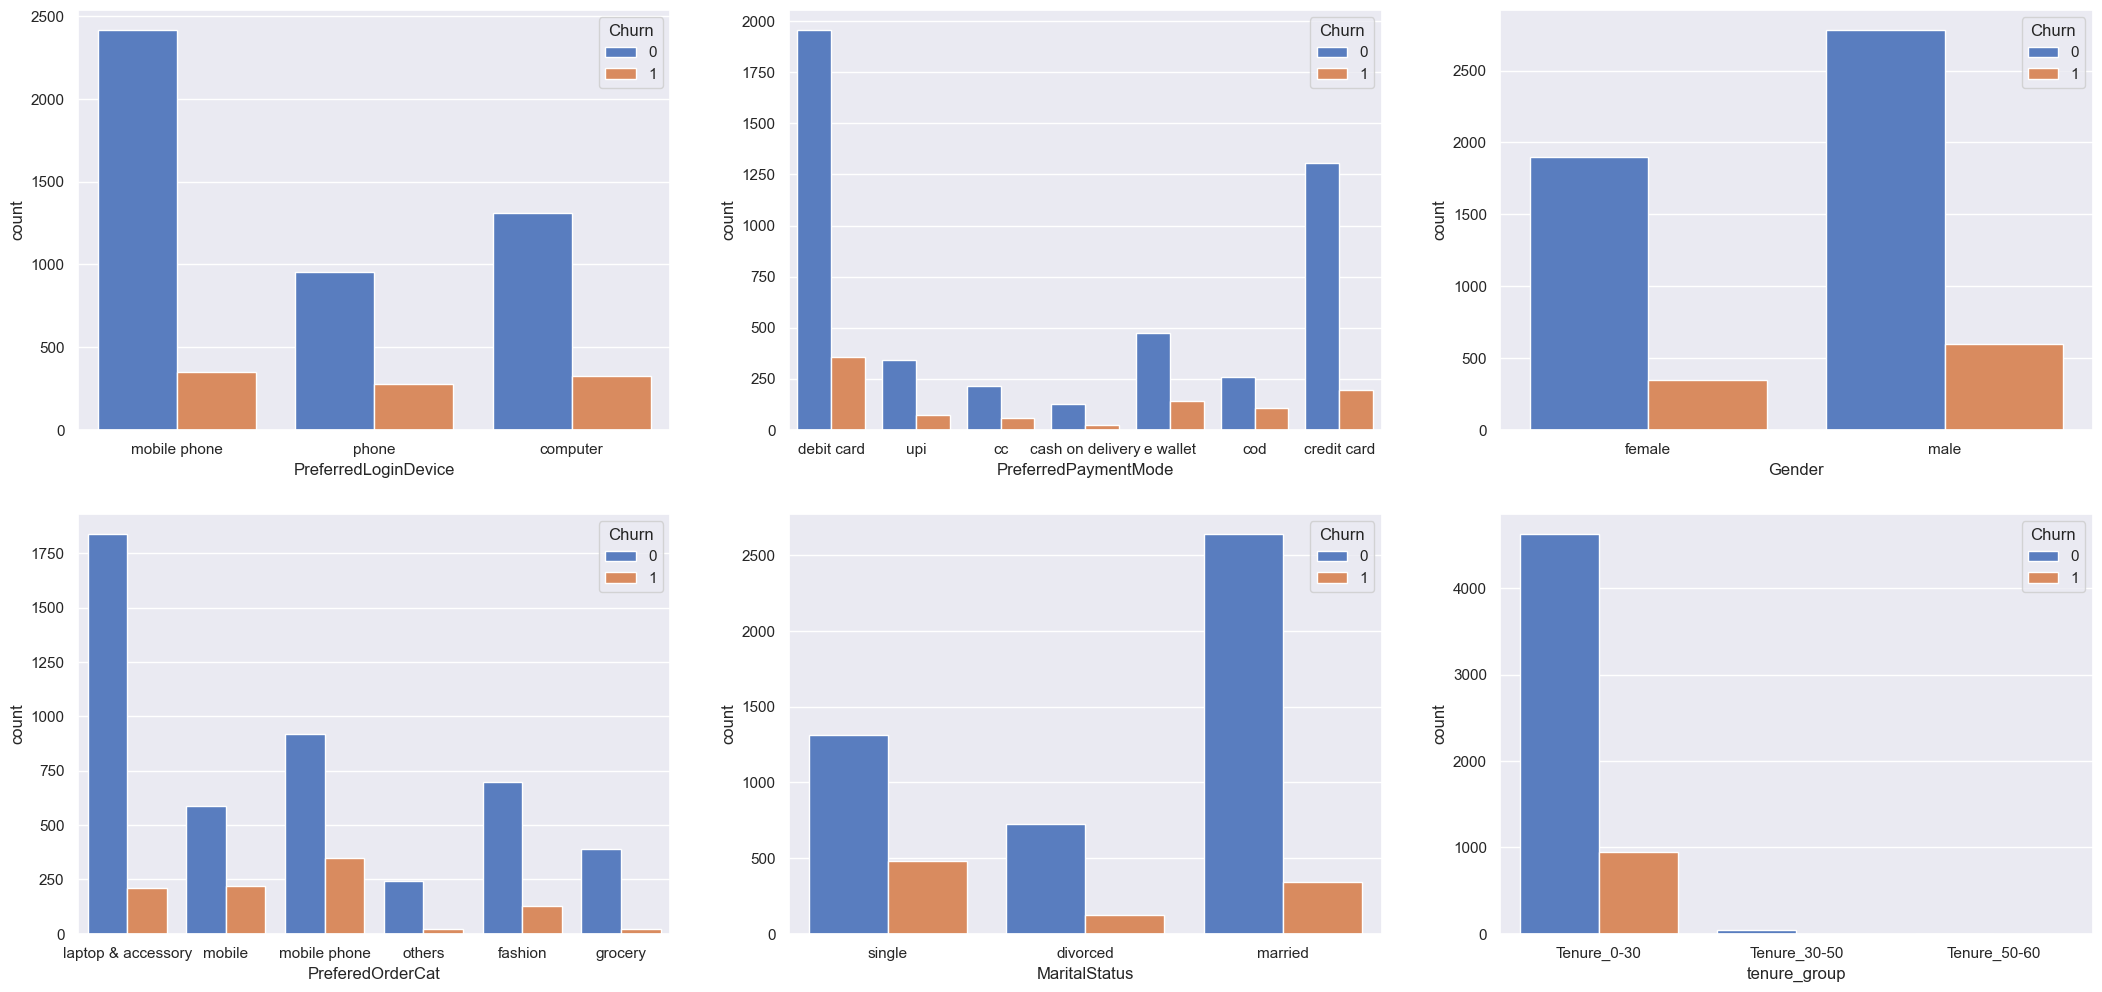

In [29]:
#Visualizing each categorical variable with the corresponding churn value
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(26,12))

for col,subplot in zip(chr_str, ax.flatten()):
  sns.countplot(x = chr_str[col], hue=chr_str.Churn, ax=subplot)

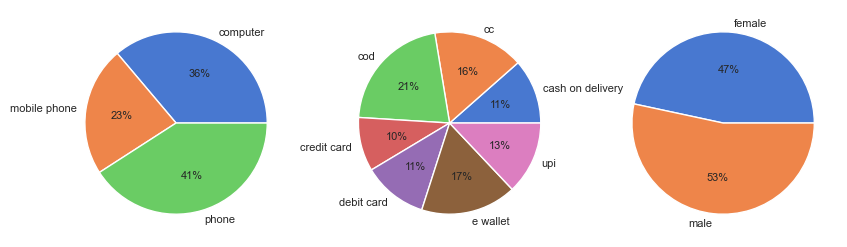

In [30]:
#Plotting the % of churn based on total number of customers (First 3 variables)
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
plt.rcParams['font.size'] = '5'
for col,subplot in zip(chr_str.iloc[:, :3], ax.flatten()):
    #calculate percent churn
    temp = chr.groupby(by=chr[col]).Churn.sum()
    total = chr.value_counts(col).sort_index()
    res1 = temp/total*100
    #visualising the result
    subplot.pie(labels = res1.index, x = res1.values, autopct='%.0f%%',textprops={'fontsize': 8})


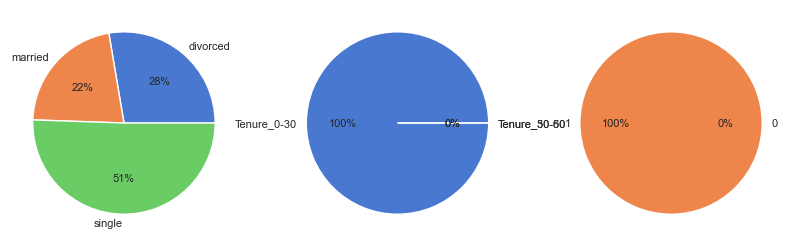

In [31]:
#Plotting the % of churn based on total number of customers (Next 3 variables)
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
plt.rcParams['font.size'] = '5'
for col,subplot in zip(chr_str.iloc[:, 4:len(chr_str)], ax.flatten()):
    #calculate percent churn
    temp = chr.groupby(by=chr[col]).Churn.sum()
    total = chr.value_counts(col).sort_index()
    res1 = temp/total*100
    #visualising the result
    subplot.pie(labels = res1.index, x = res1.values, autopct='%.0f%%',textprops={'fontsize': 8})


In [32]:
# Define a function to calculate churn rate
def calculate_churn_rate(group):
    total_customers = len(group)
    churned_customers = sum(group['Churn'] == 1)
    churn_rate = (churned_customers / total_customers) * 100
    return churn_rate

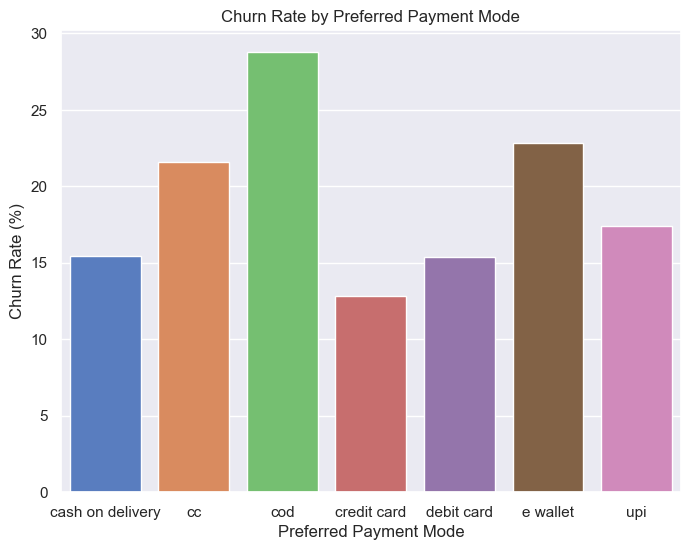

In [39]:
# Group the data by the 'PreferredPaymentMode' column
grouped_data = chr_str_plt.groupby('PreferredPaymentMode')

# Apply the calculate_churn_rate function to each group
churn_rates = grouped_data.apply(calculate_churn_rate)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))  
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.xlabel('Preferred Payment Mode')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Preferred Payment Mode')
plt.show()

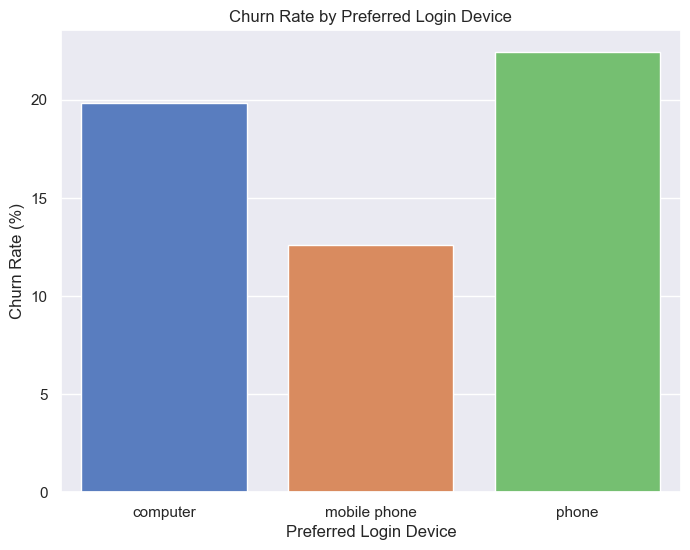

In [40]:
# Group the data by the 'PreferredLoginDevice' column
grouped_data = chr_str_plt.groupby('PreferredLoginDevice')

# Apply the calculate_churn_rate function to each group
churn_rates = grouped_data.apply(calculate_churn_rate)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6)) 
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.xlabel('Preferred Login Device')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Preferred Login Device')
plt.show()

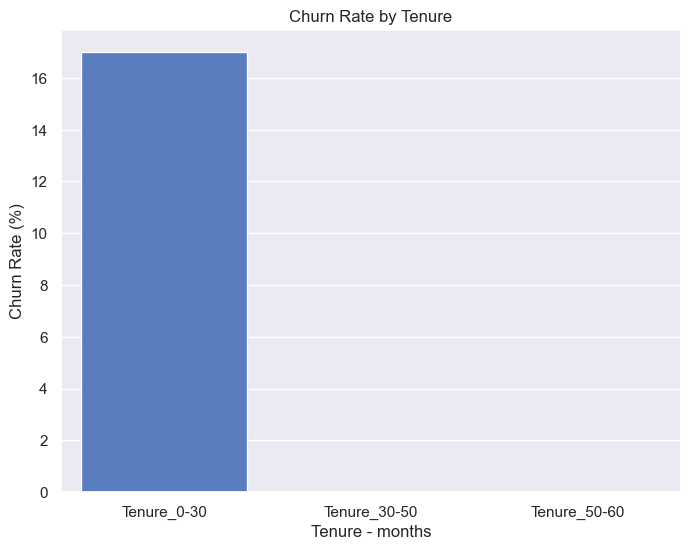

In [42]:
# Group the data by the 'Tenure' column
grouped_data = chr_str_plt.groupby('tenure_group')

# Apply the calculate_churn_rate function to each group
churn_rates = grouped_data.apply(calculate_churn_rate)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.xlabel('Tenure - months')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Tenure')
plt.show()

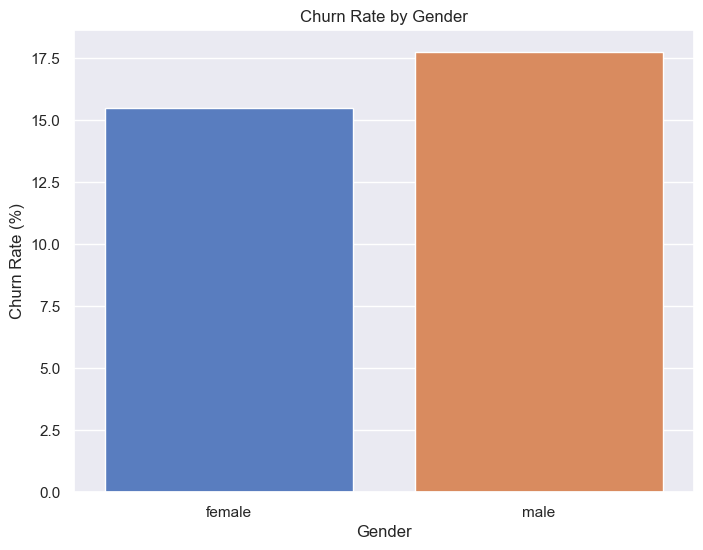

In [33]:
# Group the data by the 'Gender' column
grouped_data = chr_str_plt.groupby('Gender')

# Apply the calculate_churn_rate function to each group
churn_rates = grouped_data.apply(calculate_churn_rate)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6)) 
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.xlabel('Gender')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Gender')
plt.show()

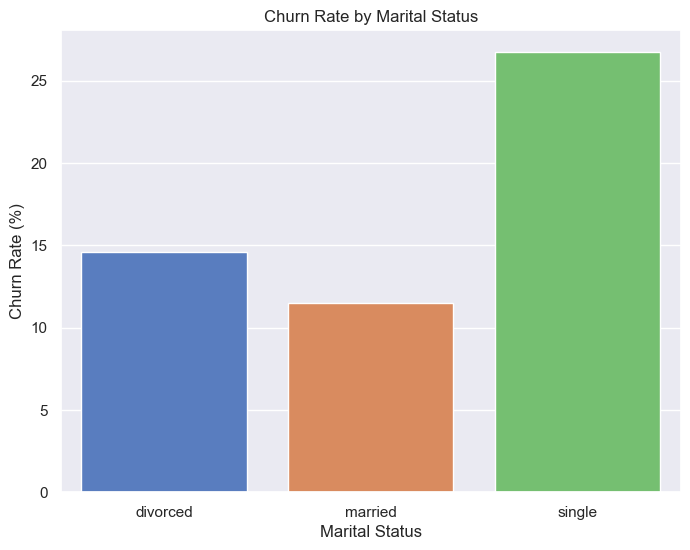

In [35]:
# Group the data by the 'MaritalStatus' column
grouped_data = chr_str_plt.groupby('MaritalStatus')

# Apply the calculate_churn_rate function to each group
churn_rates = grouped_data.apply(calculate_churn_rate)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))  
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.xlabel('Marital Status')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Marital Status')
plt.show()

#####NUMERICAL VARIABLES

In [43]:
#Selecting only non-numerical variables
chr_num = chr.select_dtypes(include=[np.number])
chr_num_plt = chr_num

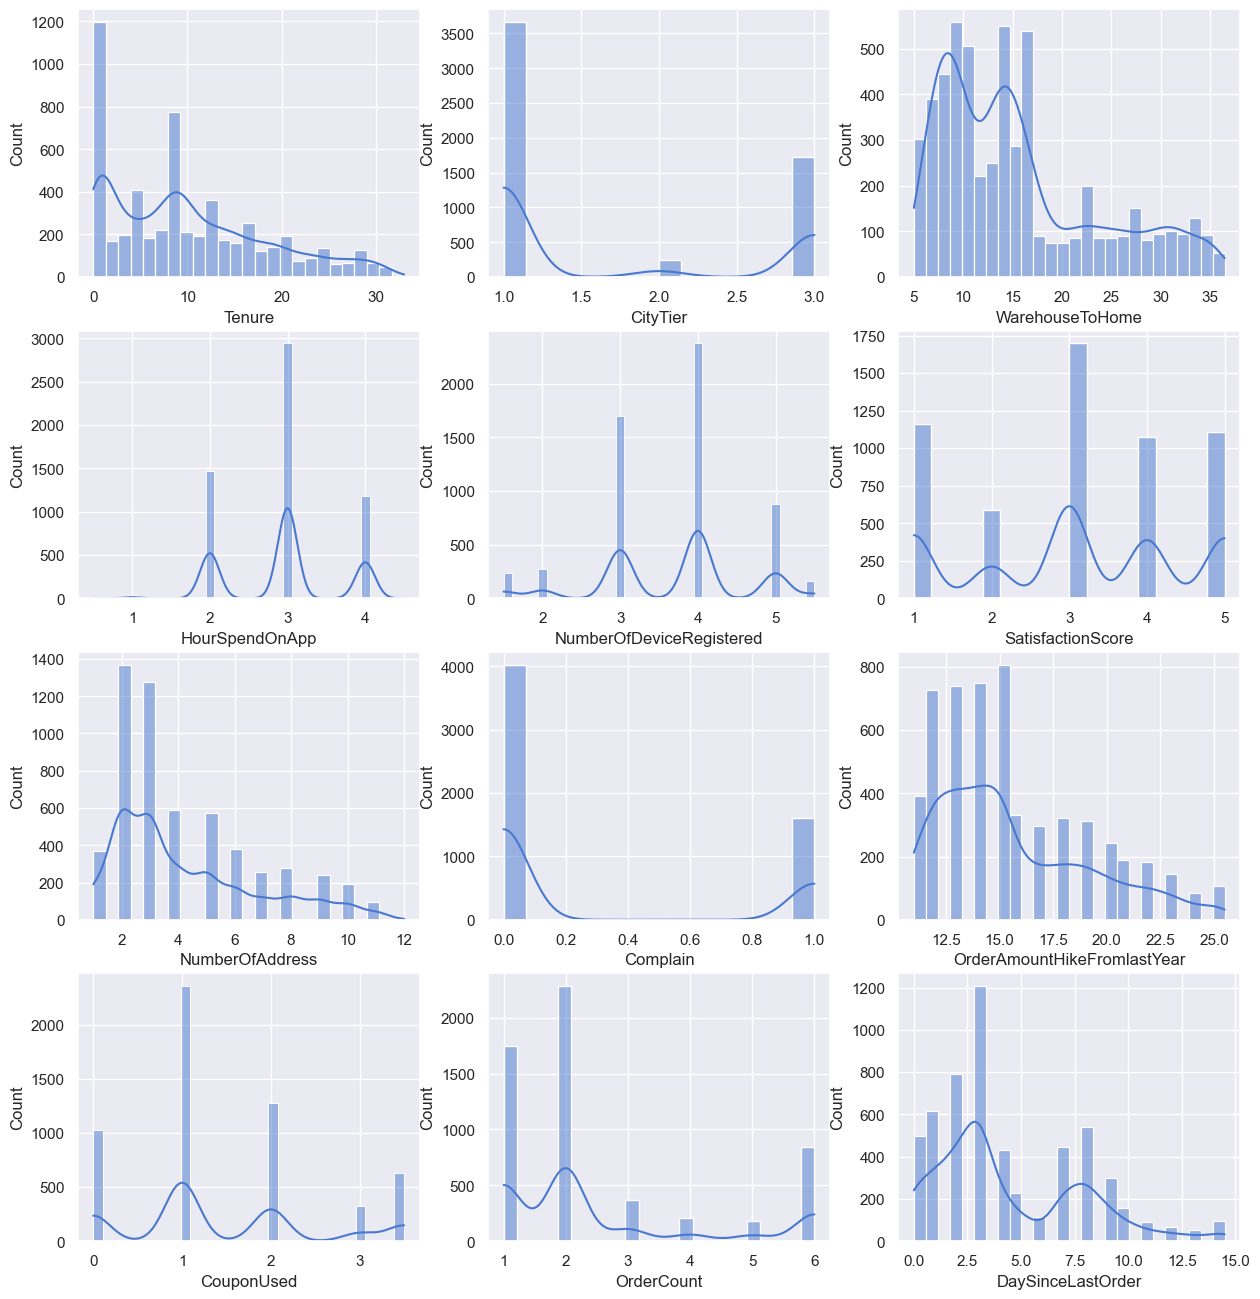

In [19]:
#Visualizing each categorical variable with the corresponding churn value
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(15,16))

for col,subplot in zip(chr_num.iloc[:, 1:len(chr_num)], ax.flatten()):
  sns.histplot(x = chr_num[col], kde = True, ax=subplot)

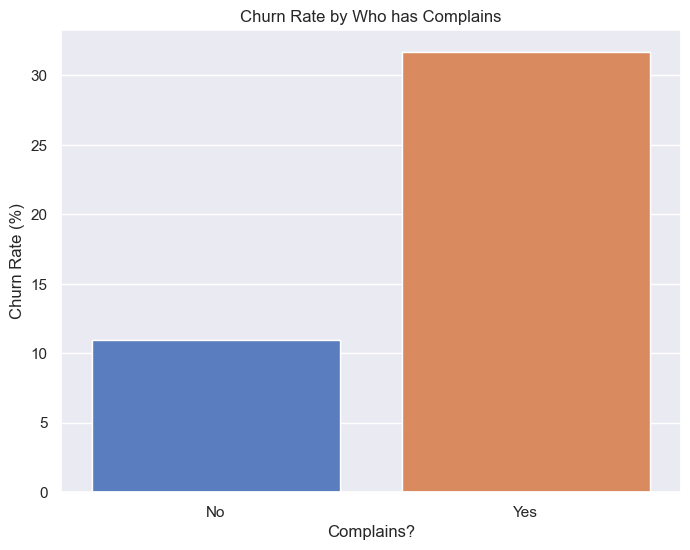

In [47]:
# Group the data by the 'Complain' column
grouped_data = chr_num_plt.groupby('Complain')

# Apply the calculate_churn_rate function to each group
churn_rates = grouped_data.apply(calculate_churn_rate)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
ax = sns.barplot(x=churn_rates.index.map({0: 'No', 1: 'Yes'}), y=churn_rates.values)
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.xlabel('Complains?')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Who has Complains')

# Define custom labels
custom_labels = ['No', 'Yes']

# Change x-axis labels from 0, 1 to 'No', 'Yes'
ax.set_xticks([0, 1])
ax.set_xticklabels(custom_labels)

plt.show()

####CORRELATION ANALYSIS

<AxesSubplot:>

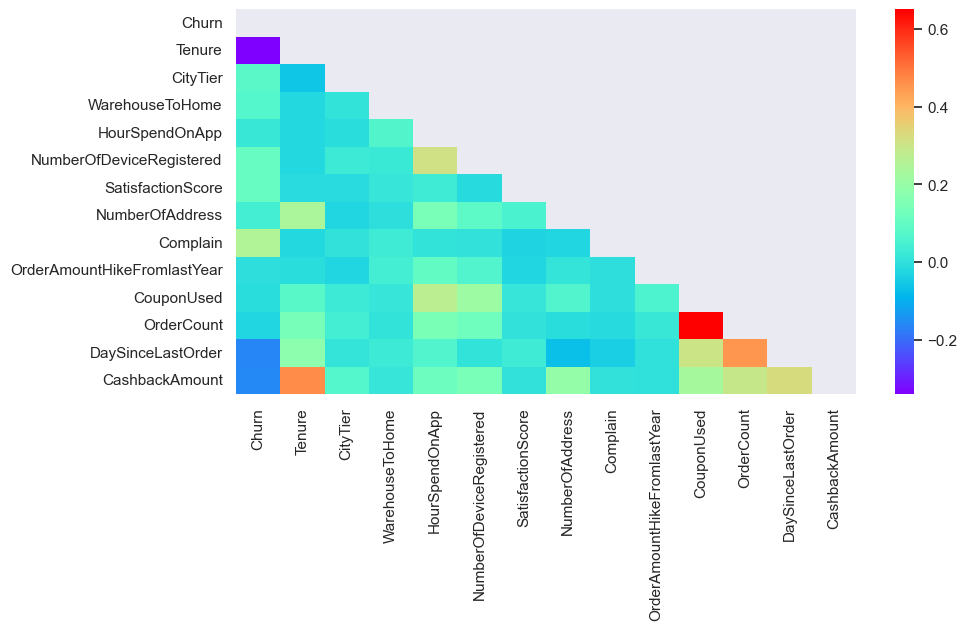

In [20]:
#Bivariate analysis using two variables and finding the relationship between them.
mask=np.zeros_like(chr.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots( figsize=(10, 5))
sns.heatmap(chr.corr(method='pearson'), mask=mask, cmap='rainbow')


#MACHINE LEARNING PREDICTIONS

####PREVIOUS STEPS TO FORMULATE THE PREDICTIONS METHODS

In [21]:
#Use of these formulas to apply what it defined previously
df_normalize_strings(chr_str, patt) #To normalize strings as per a patron
df_string_to_cat(chr_str) #To convert strins into categorical variables
df_cat_to_catcode(chr_str) #To encoder
sniff_modified(chr_str) #To check info from other view

,data type,percent missing,No. unique,unique values
PreferredLoginDevice,int8,0.0,3,"[2, 3, 1]"
PreferredPaymentMode,int8,0.0,7,"[5, 7, 2, 1, 6, 3, 4]"
Gender,int8,0.0,2,"[1, 2]"
PreferedOrderCat,int8,0.0,6,"[3, 4, 5, 6, 1, 2]"
MaritalStatus,int8,0.0,3,"[3, 1, 2]"
tenure_group,int8,0.0,3,"[1, 2, 3]"
Churn,int64,0.0,2,"[1, 0]"


In [22]:
#Dropping Churn column which is the target
chr_str = chr_str.drop(['Churn'], axis=1)
chr_num = chr_num.drop(['Churn'], axis=1)

#Merging both results to finalize the cleaning process
chr_new = pd.concat([chr_str, chr_num], axis=1)

####LOGISTIC REGRESSION METHOD


In [23]:
#Evaluating logistic regression method
model, X_train, X_test, y_train, y_test, y_pred = evaluate(X, y, 'Logistic Regression')

NameError: name 'X' is not defined

In [ ]:
#Viewwing the importance of each feature for logistic regression method
showimp(model, X, y)

In [ ]:
# Build the confusion matrix for this method
cm = confusion_matrix(y_test, y_pred)

chr_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10, 7))
sns.heatmap(chr_cm, annot = True, fmt ='g')
print("Test Data Accuracy: %.4f" %accuracy_score(y_test, y_pred))

####DECISION TREE METHOD

In [ ]:
#Using the new dataset, cleaned and worked, the new model is evaluated to check OOB and R2
#X, y = chr_new, chr[['Churn']]

In [ ]:
#Evaluating logistic regression method
model, X_train, X_test, y_train, y_test, y_pred = evaluate(X, y, 'Decision Tree')

In [ ]:
#Visualizing results
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(model, filled=True)

In [ ]:
# Build the confusion matrix for this method
cm = confusion_matrix(y_test, y_pred)

chr_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10, 7))
sns.heatmap(chr_cm, annot = True, fmt ='g')
print("Test Data Accuracy: %.4f" %accuracy_score(y_test, y_pred))